# Modeling TCLab

Alex Dowling, University of Notre Dame <br>
Jacob Krel, West Virginia University

## Raw Data

Import modules and load/parse data:

In [1]:
# -----------------------------------------------------------------------
# Local version of 'from FoKL import FoKLRoutines':
import os
import sys
dir = os.path.abspath(os.path.dirname(os.path.realpath('__file__')))  # directory of script
sys.path.append(dir)
sys.path.append(os.path.join(dir, '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
# -----------------------------------------------------------------------
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import scipy


filename = 'tclab_sine_test.csv'

data = pd.read_csv(filename)
t = data['Time'].values
T1 = data['T1']
T2 = data['T2']
Q1 = data['Q1'].values
Q2 = data['Q2'].values

Plot data:

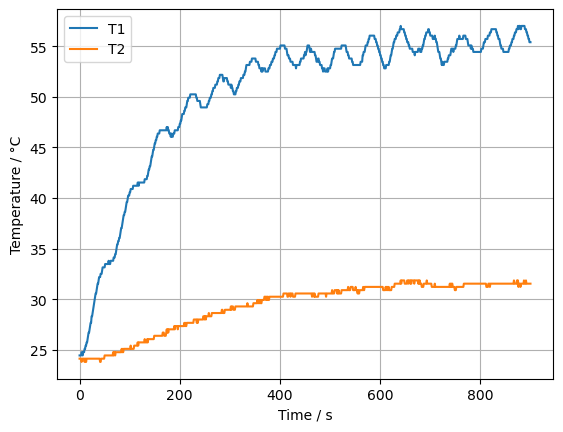

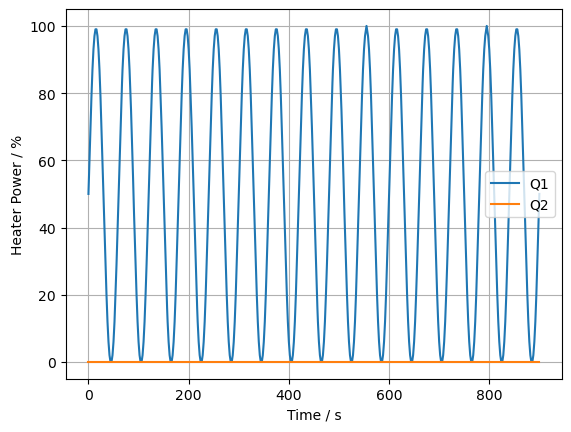

In [2]:
data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time / s', ylabel='Temperature / °C')
plt.show()

data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time / s', ylabel='Heater Power / %')
plt.show()

Assuming ```Q1``` is a sine wave with unknown analytic equation $Q_1 = A\sin(\omega t) + b$, fitting least squares to get $\omega$ (while empirically assuming $A,b=50$ otherwise ```curve_fit``` requires extremely good initial guess):

omega = 0.10472082995152394 Hz


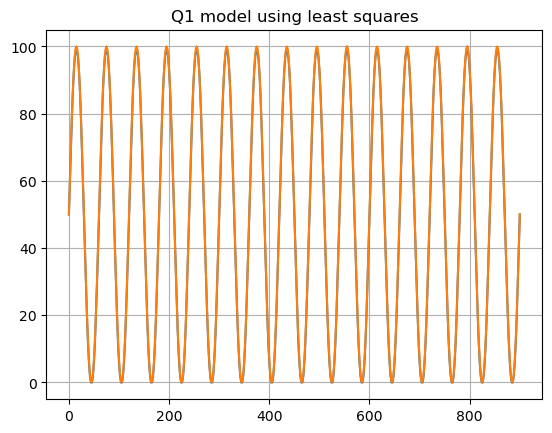

In [3]:
A, b = 50, 50

def Q1_func(t, omega):
    return A * np.sin(omega * t) + b

omega = scipy.optimize.curve_fit(Q1_func, t, Q1, 0.1)[0][0]
print(f"omega = {omega} Hz")

plt.figure()
plt.plot(t, Q1)  # actual
plt.plot(t, Q1_func(t, omega))  # predicted
plt.title('Q1 model using least squares')
plt.grid(True)
plt.show()

## GP Model

With the goal of $\frac{dT_1}{dt}$ in mind, which is challenging to model directly due to measurements of $T_1$ containing a sort of "stepwise noise", the Gaussian process (GP) model will be trained on $T_1 = f(t, Q_1)$.

In [4]:
model = FoKLRoutines.FoKL(kernel=1)
_ = model.fit([t, Q1], T1, clean=True, pillow=[[0, 0.2]] * 2, pillow_type='absolute')

/home/jacobpatrick/ESMS/support/FoKL-GPy-pyomo-tclab_support/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:273: UserWarning: 'data' was auto-converted to numpy. Convert manually for assured accuracy.
  warnings.warn("'data' was auto-converted to numpy. Convert manually for assured accuracy.",
/home/jacobpatrick/ESMS/support/FoKL-GPy-pyomo-tclab_support/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:292: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, 3592.1272475128376]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705092]
[4, 574.1060402705092]
[4, 541.268377364775]
[4, -332.9451928492086]
[5, -332.9451928492086]
[5, -332.9451928492086]
[5, -386.40386812710227]
[6, -386.40386812710227]
[6, -386.40386812710227]
[6, -387.4363500412917]
[6, -395.806886355517]
[7, -395.806886355517]
[7, -395.806886355517]
[7, -390.6963275732676]


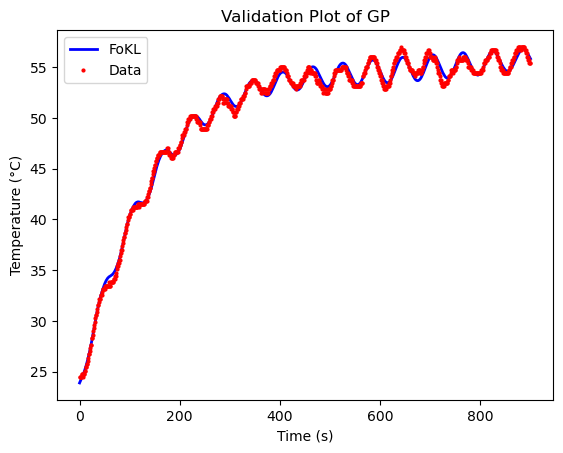

In [5]:
_ = model.coverage3(plot=True, bounds=False, title='Validation Plot of GP', xaxis=0, xlabel='Time (s)', ylabel='Temperature (°C)')

### USING ```evaluate``` - FOR SYNTAX REFERENCE

In [6]:
# Evaluate at training inputs:
T1_pred = model.evaluate()  # returns predictions at provided training [t, Q1] inputs (i.e., what is plotted in above validation plot)

# Evaluate at new inputs (provided they are within normalization bounds ... see 'pillow=[0, 0.2]' when 'fit' was called to adjust bounds):
t_new = [901, 902, 903]
Q1_new = [56, 61, 66]
T1_pred_new = model.evaluate([t_new, Q1_new], clean=True)  # returns predictions at NEW [t, Q1] inputs

/home/jacobpatrick/ESMS/support/FoKL-GPy-pyomo-tclab_support/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:282: UserWarning: 'inputs' was converted to float64. May require user-confirmation that values did not get corrupted.
  warnings.warn(f"'inputs' was converted to float{bit}. May require user-confirmation that "


## Derivative of GP Model

With $T_1(t, Q_1)$ trained, the chain rule yields:

$$
\frac{\partial T_1}{\partial t} 
= \left(\frac{\partial T_1}{\partial t}\right)_{Q_1} + \left(\frac{\partial T_1}{\partial Q_1}\right)_t \frac{\partial Q_1}{\partial t}
$$

<br>

From ```bss_derivatives```, the gradient of $T_1(t, Q_1)$ may be found. All that is needed then is $\frac{\partial Q_1}{\partial t}$, which analytically is $\frac{\partial}{\partial t}(A\sin(\omega t)+b) = A\omega\cos(\omega t)$.

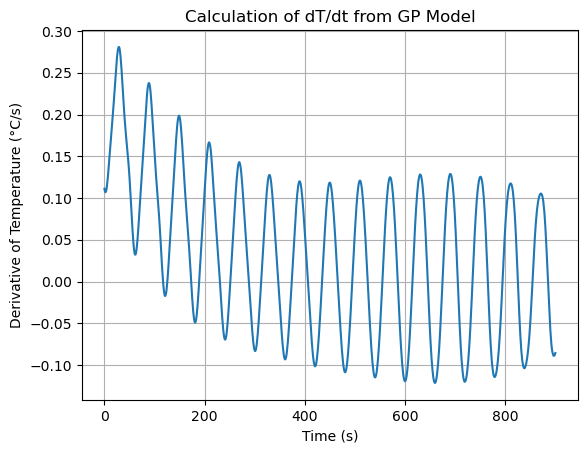

In [7]:
dGPdt = model.bss_derivatives()  # gradient of GP, i.e., of T1 = f(t, Q1)

dT1dt_Q1 = dGPdt[:, 0]  # Q1 = const.
dT1dQ1_t = dGPdt[:, 1]  # t = const.

dQ1dt = A * omega * np.cos(omega * t)  # from analytic heater power
dT1dt = dT1dt_Q1 + dT1dQ1_t * dQ1dt  # from chain rule

plt.figure()
plt.plot(t, dT1dt)
plt.title('Calculation of dT/dt from GP Model')
plt.ylabel('Derivative of Temperature (°C/s)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.show()


## GP Model to Pyomo

Alternatively to calculating $\frac{\partial T_1}{\partial t}$, the GP could be ported to Pyomo and the derivative taken there.

In [8]:
# Define Pyomo variable names:
xvars = ['t', 'Q1']
yvar = 'T1'

# For example, convert to Pyomo with only 3 scenarios so printed output is readable:
m_example = model.to_pyomo(xvars, yvar, draws=3)

# Print Pyomo model:
print("Legend of non-'xvars' and non-'yvar' Pyomo variables:\n\n \
    'j'         == index of input variable\n \
    'k'         == index of term in GP expression corresponding to beta_k coefficient\n \
    'scenarios' == index of draw\n \
    'xvar_norm' == normalized input variable\n \
    'yvar_draw' == GP expression defined with betas of indexed draw\n \
    'yvar_mean' == mean of all 'yvar_draw' values, but defined using mean of betas (so 'yvar_mean' != f('yvar_draw'[:]))\n \
    'yvar_std'  == [IN DEVELOPMENT; currently empty variable]\n \
    'yvar_var'  == variance of 'yvar_draw' values\n \
    'b'         == betas coefficients, [scenarios x terms]\n \
    'b_'        == average of betas across scenarios (used to define 'yvar_mean')\n\n")
print("Pyomo model:\n")
m_example.pprint()

Legend of non-'xvars' and non-'yvar' Pyomo variables:

     'j'         == index of input variable
     'k'         == index of term in GP expression corresponding to beta_k coefficient
     'scenarios' == index of draw
     'xvar_norm' == normalized input variable
     'yvar_draw' == GP expression defined with betas of indexed draw
     'yvar_mean' == mean of all 'yvar_draw' values, but defined using mean of betas (so 'yvar_mean' != f('yvar_draw'[:]))
     'yvar_std'  == [IN DEVELOPMENT; currently empty variable]
     'yvar_var'  == variance of 'yvar_draw' values
     'b'         == betas coefficients, [scenarios x terms]
     'b_'        == average of betas across scenarios (used to define 'yvar_mean')


Pyomo model:

3 Set Declarations
    GP0_j : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    GP0_k : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        Non

Convert to Pyomo with all draws, and note how a pre-existing Pyomo model may be passed as an argument (or use above syntax where Pyomo model is generated inside function):

In [9]:
m = pyo.ConcreteModel()
# m.stuff = pyo.Stuff(...)

m = model.to_pyomo(xvars, yvar, m)  # by default, draws = 'model.draws' defined in 'FoKLRoutines.FoKL()' initialization
# m.pprint()  # CAUTION, output is large

Differentiate $T_1$ with respect to $t$.

In [15]:
from pyomo.core.expr.calculus.derivatives import differentiate  # https://pyomo.readthedocs.io/en/stable/_modules/pyomo/core/expr/calculus/derivatives.html


m.dT1dt = differentiate(m.GP0_expr_, m.t)  # returns int; not working as desireed